## learning-AI101 : HARTH classification (DL)
### The Human Activity Recognition Trondheim (HARTH)를 Dense layer struction을 통한 ANN, DNN 방식의 classification

<br>

- **임규연 (lky473736)**
- 2024.08.04., 2024.08.23. ~ 2024.09.01.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/779/harth
- **data abstract** : The Human Activity Recognition Trondheim (HARTH) dataset is a professionally-annotated dataset containing 22 subjects wearing two 3-axial accelerometers for around 2 hours in a free-living setting. The sensors were attached to the right thigh and lower back. The professional recordings and annotations provide a promising benchmark dataset for researchers to develop innovative machine learning approaches for precise HAR in free living.

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HARTH을 classification한다. 목차는 아래와 같다.

- **1. 데이터 load and preprocessing**
- **2. ANN (fully connected)**
- **3. DNN**


In [1]:
%reset -f

In [2]:
# AMD GPU 가속화를 위한 plaidml 가동

import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K

Using plaidml.keras.backend backend.


In [3]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

------

### 1. 데이터 load 및 preprocessing
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- **자세한 EDA는 ./ML_classification_HARTH를 참고할 것**

In [4]:
# 파일 중 S006.csv를 열어서 header를 확인한다.

df_sample = pd.read_csv('../../data/harth/S006.csv')
df_sample.columns

Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label'],
      dtype='object')

In [5]:
# records 병합

import glob

directory_path = '../../data/harth'

# 모든 CSV 파일의 경로를 가져오기
all_files = glob.glob(directory_path + "/*.csv")

print (all_files)

# 데이터프레임을 담을 빈 리스트 생성
df_list = []

# 모든 파일을 순회하며 데이터프레임에 추가
for filename in all_files :
    df = pd.read_csv(filename)  
    df_list.append(df) 

merged_df = pd.concat(df_list, ignore_index=True) # 병합 (header는 ignore)
df = merged_df

df.head()

['../../data/harth/S016.csv', '../../data/harth/S017.csv', '../../data/harth/S029.csv', '../../data/harth/S015.csv', '../../data/harth/S014.csv', '../../data/harth/S028.csv', '../../data/harth/S010.csv', '../../data/harth/S013.csv', '../../data/harth/S012.csv', '../../data/harth/S006.csv', '../../data/harth/S023.csv', '../../data/harth/S022.csv', '../../data/harth/S008.csv', '../../data/harth/S020.csv', '../../data/harth/S021.csv', '../../data/harth/S009.csv', '../../data/harth/S025.csv', '../../data/harth/S019.csv', '../../data/harth/S018.csv', '../../data/harth/S024.csv', '../../data/harth/S026.csv', '../../data/harth/S027.csv']


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,index,Unnamed: 0
0,2019-01-12 00:00:00.000,-0.982201,-0.031251,0.178300,-0.935149,0.006160,-0.358898,6,NaN,NaN
1,2019-01-12 00:00:00.020,-0.973421,-0.042747,0.190618,-0.934986,0.040489,-0.366376,6,NaN,NaN
2,2019-01-12 00:00:00.040,-0.977409,-0.033531,0.185584,-0.939761,0.028617,-0.370106,6,NaN,NaN
3,2019-01-12 00:00:00.060,-0.974620,-0.034506,0.188868,-0.939667,0.036060,-0.369624,6,NaN,NaN
4,2019-01-12 00:00:00.080,-0.976828,-0.041577,0.186524,-0.946145,0.030512,-0.363411,6,NaN,NaN


In [6]:
# timestamp, index 삭제, unnamed 삭제

try : 
    del df['timestamp']
    del df['index']
except : 
    pass

df.drop(['Unnamed: 0'], axis = 1, inplace = True)
print ("현재 attribute : ", df.columns)

현재 attribute :  Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object')


In [7]:
# df의 크기 및 info
print("df 크기 : ", df.shape)
df.info()

df 크기 :  (6461328, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   back_x   float64
 1   back_y   float64
 2   back_z   float64
 3   thigh_x  float64
 4   thigh_y  float64
 5   thigh_z  float64
 6   label    int64  
dtypes: float64(6), int64(1)
memory usage: 345.1 MB


In [8]:
# df의 기본적인 정보 및 기초통계량

df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06
mean,-8.849574e-01,-1.326128e-02,-1.693779e-01,-5.948883e-01,2.087665e-02,3.749160e-01,6.783833e+00
std,3.775916e-01,2.311709e-01,3.647385e-01,6.263466e-01,3.884511e-01,7.360983e-01,1.143238e+01
min,-8.000000e+00,-4.307617e+00,-6.574463e+00,-8.000000e+00,-7.997314e+00,-8.000000e+00,1.000000e+00
25%,-1.002393e+00,-8.312914e-02,-3.720700e-01,-9.742110e-01,-1.000873e-01,-1.557138e-01,3.000000e+00
50%,-9.748998e-01,2.593677e-03,-1.374510e-01,-4.217309e-01,3.262909e-02,7.004390e-01,7.000000e+00
75%,-8.123032e-01,7.251000e-02,4.647321e-02,-1.678755e-01,1.549512e-01,9.486747e-01,7.000000e+00
max,2.291708e+00,6.491943e+00,4.909483e+00,7.999756e+00,7.999756e+00,8.406235e+00,1.400000e+02


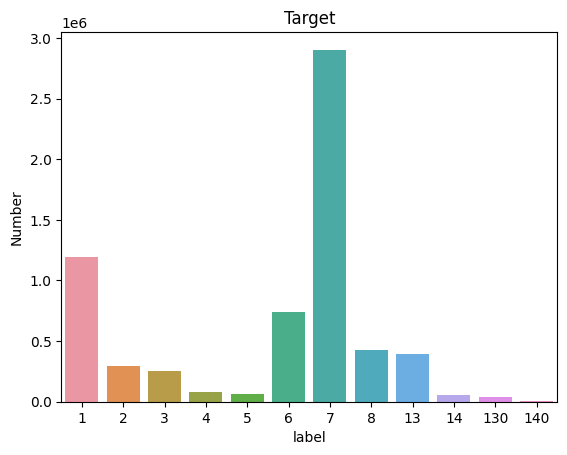

In [9]:
# seaborn countplot을 통한 각 레이블 도수 확인

sns.countplot (data=df, x='label')
plt.xlabel ("label")
plt.ylabel ("Number")
plt.title ("Target")
plt.show()

In [10]:
# target의 class 도수를 확인 (숫자로)

df['label'].value_counts()

7      2902703
1      1197155
6       743480
8       428898
13      393963
2       291356
3       254839
4        76217
5        67253
14       55814
130      41785
140       7865
Name: label, dtype: int64

위 target을 countplot으로 표현한 figure을 보았을 때, 알 수 있는 사실은 다음과 같다.
- **7**이 압도적인데, 7은 **sitting**, 즉 앉아 있는 것을 의미한다.
- 각 target의 번호를 맞추어주어야 할 것 같다. 13을 9로, 14를 10으로, 130을 11로, 140을 12로 수정한다.
- 또한, 전체 label의 구성을 바꾸어주어야 한다.
    - **sparse_crossentropy는 클래스를 0부터 인식한다.** 따라서, 현재 1~12로 class를 구성하고 output layer의 node 수를 12로 설정하면 **INVALID_ARGUMENT** 에러가 날 것이다.
    - 따라서, 각 class를 1-based가 아닌, **0-based**로 수정한다.

In [11]:
# # iterrows를 사용하여 각 행에 접근

# for index, row in df.iterrows() :
#     compo_label = df.at[index, 'label']
    
#     if compo_label == 13 :
#         df.at[index, 'label'] = 9
        
#     elif compo_label == 14 : 
#         df.at[index, 'label'] = 10
        
#     elif compo_label == 130 : 
#         df.at[index, 'label'] = 11
        
#     elif compo_label == 140 : 
#         df.at[index, 'label'] = 12

df['label'] = df['label'].replace({13: 9, 14: 10, 130: 11, 140: 12})

for_0_based = dict()
for i in range (12) : 
    for_0_based[i+1] = i
    
df['label'] = df['label'].replace(for_0_based)

# label 열의 고유값을 출력
print (df['label'].unique())


[ 5  2  0  6  1  7  4  3  8 10  9 11]


In [12]:
# input과 target으로 split

harth_input = df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].to_numpy() 
harth_target = df['label'].to_numpy()

In [13]:
# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split
# 또한, X_train, y_train, X_val, y_val로 train set, validation set 각각 8:2로 split

X_train, X_test, y_train, y_test = train_test_split(harth_input, harth_target, 
                                                   stratify=harth_target, 
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                        test_size=0.2, 
                                                        stratify=y_train)

In [14]:
# StandardScaler을 통한 정규화 진행

ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)
X_val_scaled = ss_transformer.transform(X_val)

In [15]:
# feature 늘리기 (추후 사용)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly.fit(X_train)

X_train_poly = poly.transform (X_train)
X_test_poly = poly.transform (X_test)
X_val_poly = poly.transform (X_val)

print (f"shape | X_train_poly : {X_train_poly.shape}, X_test_poly : {X_test_poly.shape}")
print (f"poly | {poly.get_feature_names_out()}")

ss_transformer = StandardScaler()

ss_transformer.fit(X_train_poly)

X_train_poly_scaled = ss_transformer.transform(X_train_poly)
X_test_poly_scaled = ss_transformer.transform(X_test_poly)
X_val_poly_scaled = ss_transformer.transform(X_val_poly)

shape | X_train_poly : (4135249, 28), X_test_poly : (1292266, 28)
poly | ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4'
 'x0 x5' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5' 'x2^2' 'x2 x3' 'x2 x4'
 'x2 x5' 'x3^2' 'x3 x4' 'x3 x5' 'x4^2' 'x4 x5' 'x5^2']


------

### 2. ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 또한 loss function은 sparse_categorical_crossentropy를 사용한다.

In [16]:
# modelling (다중 분류)

from keras.utils import plot_model

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential()
model.add(keras.layers.Dense(6, input_shape=(6, )))
model.add(keras.layers.Dense(12, activation='softmax'))

model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


records shape :  (7,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 12)                84        
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [17]:
# compile

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
# fit
# early stopping callback을 통하여 overfitting 방지

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                 restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[early_stopping_cb], batch_size=512, 
                    verbose=True)

print (history.history)

Train on 4135249 samples, validate on 1033813 samples
Epoch 1/100
4135249/4135249 [==============================] - 60s 14us/step - loss: 1.1073 - acc: 0.6526 - val_loss: 1.0629 - val_acc: 0.6607
Epoch 2/100
4135249/4135249 [==============================] - 59s 14us/step - loss: 1.0647 - acc: 0.6605 - val_loss: 1.0628 - val_acc: 0.6602
Epoch 3/100
4135249/4135249 [==============================] - 61s 15us/step - loss: 1.0647 - acc: 0.6604 - val_loss: 1.0628 - val_acc: 0.6612
Epoch 4/100
4135249/4135249 [==============================] - 56s 14us/step - loss: 1.0646 - acc: 0.6605 - val_loss: 1.0627 - val_acc: 0.6602
Epoch 5/100
4135249/4135249 [==============================] - 54s 13us/step - loss: 1.0646 - acc: 0.6605 - val_loss: 1.0628 - val_acc: 0.6596
Epoch 6/100
4135249/4135249 [==============================] - 62s 15us/step - loss: 1.0646 - acc: 0.6605 - val_loss: 1.0628 - val_acc: 0.6609
Epoch 7/100
4135249/4135249 [==============================] - 65s 16us/step - loss: 1.0

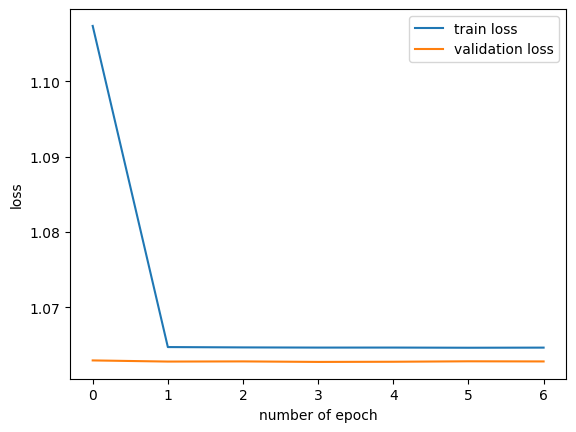

In [19]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

위 결과를 파악하면 다음과 같은 결과를 알 수 있다. 


- 일단은, accuracy가 약 0.6608를 유지하고 있다. 이는 ./ML_classification_HARTH에서 logistic regression 수행 시 cross-validation score인 0.6607과 거의 비슷하다.
- 왜 계속 accuracy가 유지되는지를 생각해보았을 때, 아래와 같은 근거를 찾을 수 있었다.
    - ./ML_classification_HARTH의 heatmap을 보았을 때 알 수 있듯이, 대부분의 feature correlation이 매우 저조한 것을 알 수 있다. 따라서 label에 미치는 영향이 그리 크지 않기에 epoch를 1~2번만 해도 특정 accuracy에 수렴할 수도 있다는 것.
    - 모델이 너무 단순해서 그럴지도 모른다.
    - feature가 너무 적어서 최적의 weight, bias를 금새 찾았을 지도 모른다.
- 그래도 train loss는 epoch 1에서 일정량 줄어들었으며, validation loss는 일정히 유지하고 있다.
    
PolynormialFeatures를 통하여 feature을 늘린 **X_train_poly_scaled**를 이용하여 다시 시도하여 본다.

In [22]:
# 모델 재조정 및 재학습

model = keras.Sequential()
model.add(keras.layers.Dense(28, input_shape=(28, ), activation='relu'))
model.add(keras.layers.Dense(12, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_poly_scaled, y_train, epochs=100, 
                    validation_data=(X_val_poly_scaled, y_val), batch_size=512, 
                   callbacks=[early_stopping_cb], 
                    verbose=True)

print (history.history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                348       
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________
Train on 4135249 samples, validate on 1033813 samples
Epoch 1/100
4135249/4135249 [==============================] - 64s 15us/step - loss: 0.5091 - acc: 0.8439 - val_loss: 0.4311 - val_acc: 0.8659
Epoch 2/100
4135249/4135249 [==============================] - 57s 14us/step - loss: 0.4212 - acc: 0.8670 - val_loss: 0.4150 - val_acc: 0.8685
Epoch 3/100
4135249/4135249 [==============================] - 49s 12us/step - loss: 0.4108 - acc: 0.8696 - val_loss: 0.4077 - val_acc: 0.8706
Epoch 4/100
4135249/4135249 [========================

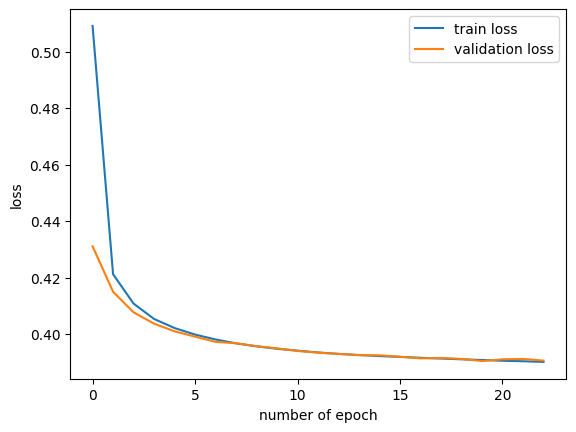

In [23]:
# loss 재시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

**feature를 늘렸더니 전보다 더욱 accuracy가 높아졌으며, overfitting 또한 잘 제어하는 것을 확인 가능하다. 확인 가능하다. 추후엔 계속 poly set으로 학습을 진행한다.**

-------

### 3. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - 각 node의 activation은 relu 사용
    - epoch는 100으로 고정
    - records가 너무 많아 batch_size를 256으로 하여 학습한다.
- 아래와 같이 experiment할 예정이다.
    - optimizer는 **적응형 학습율 optimizer인 adam을 사용한다.**
    - validation loss 감소를 위하여 **dropout 층을 추가 후, callback으로 early stopping을 도입**한다.
        - patiences는 3로 한다.
    - **overfitting을 막기 위해 Dropout 층을 배치**한다.

In [24]:
# modelling DNN
# 여기서는 feature를 늘린 X_train_poly_scaled를 사용한다.

model = Sequential([
    Dense(28, activation='relu', input_shape=(28, )),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(12, activation='softmax')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1856      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 12)                204       
Total para

In [25]:
# compile

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# callback 설정 및 fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                 restore_best_weights=True)

history = model.fit(X_train_poly_scaled, y_train, epochs=100, 
                    validation_data=(X_val_poly_scaled, y_val), batch_size=512, 
                    callbacks=[early_stopping_cb], verbose=True)

Train on 4135249 samples, validate on 1033813 samples
Epoch 1/100
4135249/4135249 [==============================] - 154s 37us/step - loss: 0.4993 - acc: 0.8456 - val_loss: 0.3977 - val_acc: 0.8723
Epoch 2/100
4135249/4135249 [==============================] - 125s 30us/step - loss: 0.4242 - acc: 0.8663 - val_loss: 0.3868 - val_acc: 0.8750
Epoch 3/100
4135249/4135249 [==============================] - 125s 30us/step - loss: 0.4147 - acc: 0.8684 - val_loss: 0.3863 - val_acc: 0.8750
Epoch 4/100
4135249/4135249 [==============================] - 138s 33us/step - loss: 0.4094 - acc: 0.8695 - val_loss: 0.3829 - val_acc: 0.8769
Epoch 5/100
4135249/4135249 [==============================] - 136s 33us/step - loss: 0.4060 - acc: 0.8702 - val_loss: 0.3781 - val_acc: 0.8776
Epoch 6/100
2217472/4135249 [===============>..............] - ETA: 1:39 - loss: 0.4042 - acc: 0.8709

/Users/alphastation/.pyenv/versions/3.7.16/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112478). Check your callbacks.
  % delta_t_median)


4135249/4135249 [==============================] - 238s 57us/step - loss: 0.4039 - acc: 0.8709 - val_loss: 0.3791 - val_acc: 0.8775
Epoch 7/100
4135249/4135249 [==============================] - 227s 55us/step - loss: 0.4023 - acc: 0.8713 - val_loss: 0.3760 - val_acc: 0.8782
Epoch 8/100
4135249/4135249 [==============================] - 146s 35us/step - loss: 0.4013 - acc: 0.8715 - val_loss: 0.3763 - val_acc: 0.8783
Epoch 9/100
4135249/4135249 [==============================] - 138s 33us/step - loss: 0.3998 - acc: 0.8720 - val_loss: 0.3756 - val_acc: 0.8786
Epoch 10/100
4135249/4135249 [==============================] - 138s 33us/step - loss: 0.3987 - acc: 0.8723 - val_loss: 0.3734 - val_acc: 0.8791
Epoch 11/100
4135249/4135249 [==============================] - 226s 55us/step - loss: 0.3983 - acc: 0.8724 - val_loss: 0.3722 - val_acc: 0.8792
Epoch 12/100
4135249/4135249 [==============================] - 164s 40us/step - loss: 0.3973 - acc: 0.8724 - val_loss: 0.3729 - val_acc: 0.8794
E

{'val_loss': [0.3976624397843877, 0.3867798786899711, 0.38626561215011324, 0.3828724711590325, 0.3780592930334533, 0.37914233897679706, 0.3759775182890497, 0.3762870697200433, 0.3756493482272256, 0.3733994242440646, 0.372245405417341, 0.3728684553616709, 0.37086210546649634, 0.3700901549028225, 0.3715636004501677, 0.3708283400317601, 0.3694246215602759, 0.37025397813888883, 0.37030444208494734, 0.3706999251201311], 'val_acc': [0.8723463527742983, 0.8750305906394243, 0.8750451000333472, 0.8769129426701499, 0.8775532905862995, 0.877460430465389, 0.8781946057949123, 0.8782797275723703, 0.8786356913685307, 0.8790564637905073, 0.879227674638117, 0.8793572918900374, 0.8791251415881937, 0.8794066238291792, 0.8790874171642017, 0.879103861143858, 0.8798302981299864, 0.8791764081131842, 0.8794037219504062, 0.878893958579159], 'loss': [0.4992849553994353, 0.42418969751234853, 0.414661091329724, 0.4094180135595756, 0.4059728886229845, 0.4038676237982792, 0.4023448585282876, 0.40128360661802115, 0.

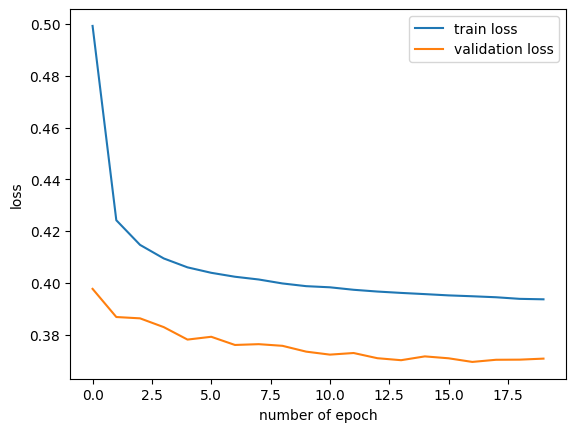

In [27]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [28]:
# evaluate

model.evaluate(X_val_poly_scaled, y_val)

1033813/1033813 [==============================] - 347s 336us/step


[0.36942462691854383, 0.8798302981295828]

In [29]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val_poly_scaled)
y_test_pred = model.predict(X_test_poly_scaled)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

- validation data confusion matrix -

[[167726   1976   3615      0      0  11122    552     22   4977   1301
     230     24]
 [  7640  37907     12      0      0     58    313     49    258    375
       5      0]
 [ 16254    122   4979      0      0  17796    370     15    931    123
     169     15]
 [  8841    394    169      0      0    485     54      0   1882    311
      53      6]
 [  8969    715     57      0      1    181     17      0    623    187
      10      1]
 [  8731     94   2332      0      0 106292    658      9    549     82
     183     27]
 [   737    110     25      0      0    281 462529     55    660      2
      34      0]
 [    36     73      0      0      0      1    111  68385     17      1
       0      0]
 [  4610    285     47      0      0    446    356      6  54457   1141
    1616     70]
 [  1206    197      4      0      0    166      5      2   2043   4888
     245    174]
 [   426     20     11      0      0    404     47      0   3391    303


/Users/alphastation/.pyenv/versions/3.7.16/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alphastation/.pyenv/versions/3.7.16/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alphastation/.pyenv/versions/3.7.16/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

- validation data report of classification -

              precision    recall  f1-score   support

           0       0.74      0.88      0.80    191545
           1       0.90      0.81      0.86     46617
           2       0.44      0.12      0.19     40774
           3       0.00      0.00      0.00     12195
           4       1.00      0.00      0.00     10761
           5       0.77      0.89      0.83    118957
           6       0.99      1.00      1.00    464433
           7       1.00      1.00      1.00     68624
           8       0.78      0.86      0.82     63034
           9       0.56      0.55      0.55      8930
          10       0.44      0.31      0.36      6685
          11       0.51      0.29      0.37      1258

    accuracy                           0.88   1033813
   macro avg       0.68      0.56      0.56   1033813
weighted avg       0.86      0.88      0.86   1033813


 --------------- 



/Users/alphastation/.pyenv/versions/3.7.16/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alphastation/.pyenv/versions/3.7.16/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- test data report of classification -

              precision    recall  f1-score   support

           0       0.74      0.88      0.80    239431
           1       0.91      0.81      0.85     58271
           2       0.43      0.12      0.19     50968
           3       0.00      0.00      0.00     15243
           4       0.00      0.00      0.00     13450
           5       0.77      0.89      0.83    148696
           6       0.99      1.00      1.00    580541
           7       1.00      1.00      1.00     85780
           8       0.78      0.86      0.82     78793
           9       0.55      0.55      0.55     11163
          10       0.43      0.31      0.36      8357
          11       0.51      0.31      0.38      1573

    accuracy                           0.88   1292266
   macro avg       0.59      0.56      0.56   1292266
weighted avg       0.85      0.88      0.86   1292266


 --------------- 



/Users/alphastation/.pyenv/versions/3.7.16/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


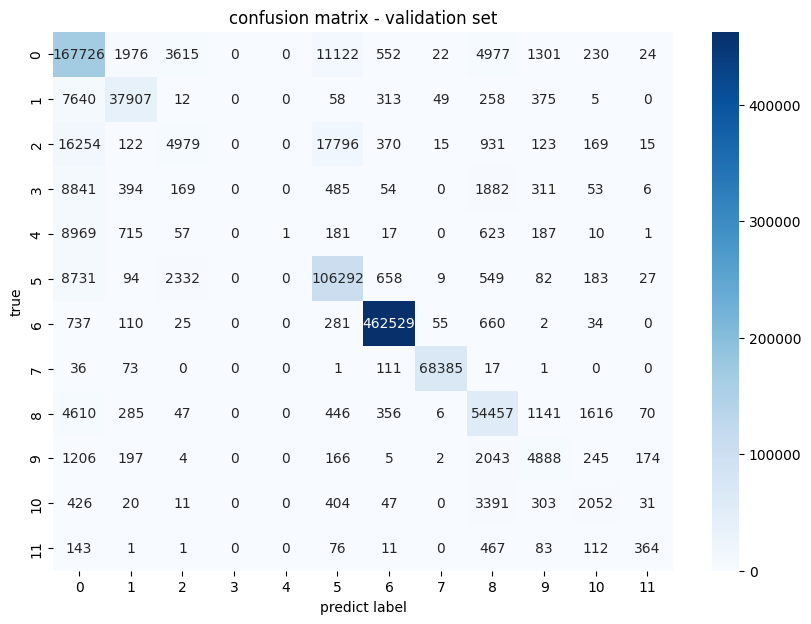

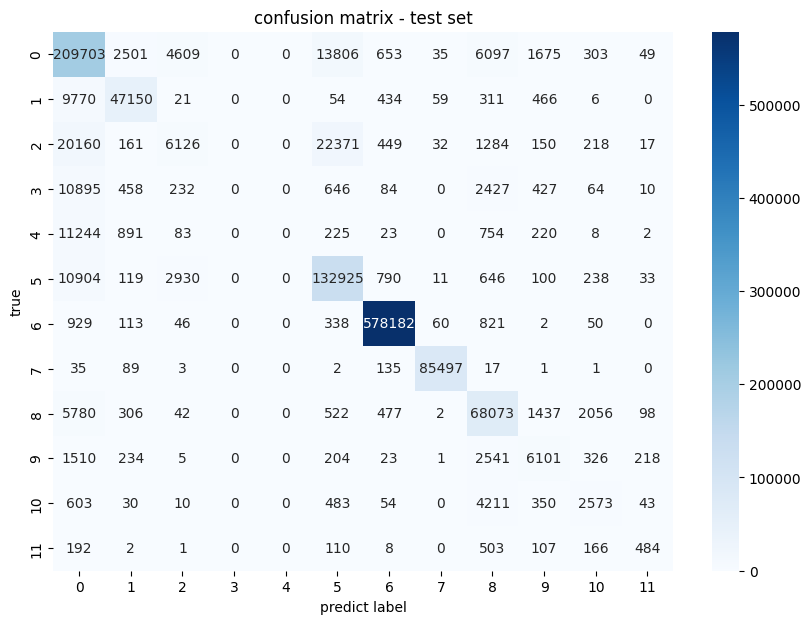

In [30]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - validation set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - test set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()